In [1]:
from modsim import *
import pandas as pd

In [4]:
data = pd.read_csv('glucose_insulin.csv', index_col='time')
data.head()

,glucose,insulin
time,,
0,92,11
2,350,26
4,287,130
6,251,85
8,240,51


In [5]:
G0 = 270
k1 = 0.02
k2 = 0.02
k3 = 1.5e-05
params = G0, k1, k2, k3

In [6]:
def make_system(params, data):
    G0, k1, k2, k3 = params
    t_0 = data.index[0]
    t_end = data.index[-1]
    Gb = data.glucose[t_0]
    Ib = data.insulin[t_0]
    I = interpolate(data.insulin)
    init = State(G=G0, X=0)
    return System(init=init, params=params, Gb=Gb, Ib=Ib, I=I, t_0=t_0, t_end=t_end, dt=2)

In [10]:
system = make_system(params, data)
system, system.init.index

(namespace(init=G    270
                X      0
                Name: state, dtype: int64,
           params=(270, 0.02, 0.02, 1.5e-05),
           Gb=np.int64(92),
           Ib=np.int64(11),
           I=<scipy.interpolate._interpolate.interp1d at 0x11fa26990>,
           t_0=np.int64(0),
           t_end=np.int64(182),
           dt=2),
 Index(['G', 'X'], dtype='object'))

$$dG = \left[ -k_1 \left[ G(t) - G_b \right] - X(t) G(t) \right] dt$$

$$dX = \left[ k_3 \left[I(t) - I_b \right] - k_2 X(t) \right] dt$$ 

In [8]:
def update_func(t, state, system):
    G0, k1, k2, k3 = system.params
    G, X = state
    Gb, Ib = system.Gb, system.Ib
    dt = system.dt
    I = system.I
    dG = (-k1 * (G - Gb) - X * G) * dt
    dX = (k3 * (I(t) - Ib) - k2 * X) * dt
    G += dG
    X += dX
    return State(G=G, X=X)

In [9]:
update_func(system.t_0, system.init, system)    

G    262.88
X      0.00
Name: state, dtype: float64

In [11]:
def run_simulation(system, update_func):
    t_array = linrange(system.t_0, system.t_end, system.dt)
    n = len(t_array)
    frame = TimeFrame(index=t_array, columns=system.init.index)
    frame.iloc[0] = system.init
    for i in range(n-1):
        t = t_array[i]
        state = frame.iloc[i]
        frame.iloc[i+1] = update_func(t, state, system)
    return frame

In [13]:
results = run_simulation(system, update_func)
len(results), results.head()

(92,
               G         X
 0.0  270.000000  0.000000
 2.0  262.880000  0.000000
 4.0  256.044800  0.000450
 6.0  249.252568  0.004002
 8.0  240.967447  0.006062)

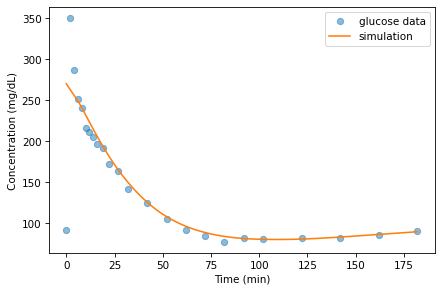

In [14]:
data.glucose.plot(style='o', label='glucose data', alpha=0.5)
results.G.plot(label='simulation', style='-')
decorate(xlabel='Time (min)', ylabel='Concentration (mg/dL)')

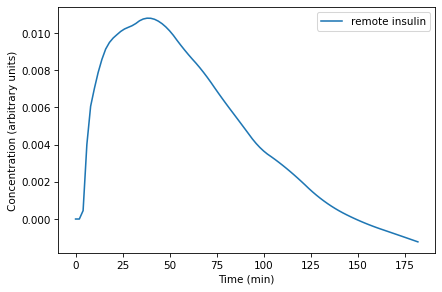

In [16]:
results.X.plot(label='remote insulin')
decorate(xlabel='Time (min)', ylabel='Concentration (arbitrary units)')

In [17]:
def slope_func(t, state, system):
    G, X = state
    G0, k1, k2, k3 = system.params
    Gb, Ib, I = system.Gb, system.Ib, system.I
    dGdt = -k1 * (G - Gb) - X * G
    dXdt = k3 * (I(t) - Ib) - k2 * X
    return dGdt, dXdt

In [18]:
results2, details = run_solve_ivp(system, slope_func, t_eval=results.index)

In [19]:
details

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
      sol: None
 t_events: None
 y_events: None
     nfev: 80
     njev: 0
      nlu: 0

In [20]:
results2.head()

,G,X
0.0,270.000000,0.000000
2.0,262.980942,0.000240
4.0,255.683455,0.002525
6.0,247.315442,0.005174
8.0,238.271851,0.006602


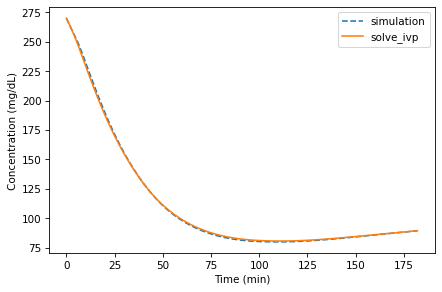

In [25]:
results.G.plot(style='--', label='simulation')
results2.G.plot(style='-', label='solve_ivp')
decorate(xlabel='Time (min)', ylabel='Concentration (mg/dL)')

<Axes: >

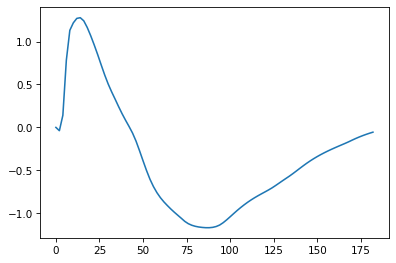

In [26]:
diff = results.G - results2.G
percent_diff = diff / results2.G * 100
percent_diff.plot()

In [28]:
percent_diff.abs().describe()

count    92.000000
mean      0.649121
std       0.392903
min       0.000000
25%       0.274854
50%       0.684262
75%       1.009868
max       1.278168
Name: G, dtype: float64

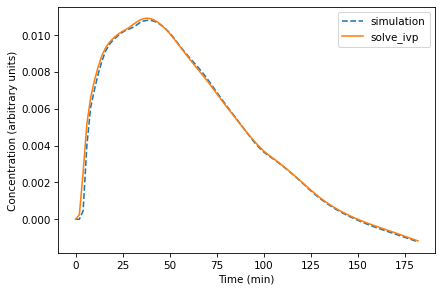

In [29]:
results.X.plot(style='--', label='simulation')
results2.X.plot(style='-', label='solve_ivp')
decorate(xlabel='Time (min)', ylabel='Concentration (arbitrary units)')

<Axes: >

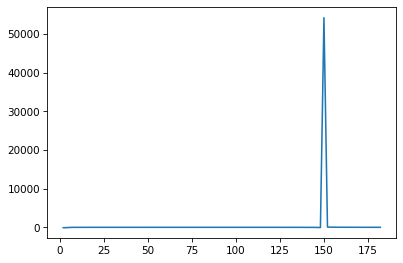

In [31]:
X_percent_diff = ((results.X - results2.X)/results2.X * 100)
X_percent_diff.plot()

In [32]:
# try solve_ivp 
from scipy.integrate import solve_ivp
bunch = solve_ivp(slope_func, [system.t_0, system.t_end], system.init,
                      args=[system])
bunch

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.659e-01  1.825e+00  7.767e+00  1.371e+01
             2.597e+01  4.569e+01  7.304e+01  1.031e+02  1.330e+02
             1.693e+02  1.820e+02]
        y: [[ 2.700e+02  2.694e+02 ...  8.744e+01  8.941e+01]
            [ 0.000e+00  1.547e-06 ... -7.186e-04 -1.178e-03]]
      sol: None
 t_events: None
 y_events: None
     nfev: 80
     njev: 0
      nlu: 0

In [33]:
y = bunch.y
t = bunch.t
results_from_solve_ivp = TimeFrame(index=t, columns=system.init.index, data=y.T)
results_from_solve_ivp.head()

,G,X
0.000000,270.000000,0.000000
0.165910,269.410317,0.000002
1.825009,263.590434,0.000185
7.767466,239.317714,0.006480
13.709923,212.995740,0.008808


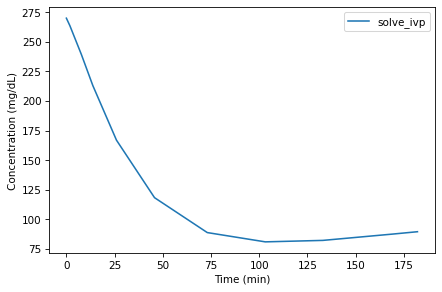

In [34]:
results_from_solve_ivp.G.plot(style='-', label='solve_ivp')
decorate(xlabel='Time (min)', ylabel='Concentration (mg/dL)')